In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_pinball_loss

In [2]:
# load data
pd.set_option('display.max_rows', 10000) 
pd.set_option('display.max_columns', 1000)
df = pd.read_excel('~/nfl_dashboard/ml_models/data/rb_data.xlsx')
df.drop(['Clean_Name','DR','G_Y2','G_Y3','Y1_PPR_Pts','Pts_Y2','Pts_Y3','Y1-Y3_Total_PPR','Y1-Y3_Tot_G','Y1-Y3_PPR_PPG'], axis=1, inplace=True)
df.sort_values(by='Draft_Year', ascending=False, inplace=True, ignore_index=True)

# split data
labels_all = df.iloc[:, 0:5]
x_all = df.iloc[:, 5:-2] # all features
y_all = df.iloc[:, -1:] # all y data
train_x = df.iloc[19:, 5:-2] # features with at least 3 nfl years
train_y = df.iloc[19:, -1:] # y data with at least 3 nfl years

In [3]:
df.head()

,Name,School,Conference,Draft_Year,Landing_Team,DP,Age_IN_DRAFT_YEAR,BOA_15%,BOA_20%,Career_YPTch,Career_YTMA_Dominator,Career_ADJ_YTMA_Dominator,First_REC_Yards_%,Best_REC_Yards_%,Last_REC_Yards_%,AVG_REC_Yards_%,RUSH%_AVG,First_ADJ_YTMA,Best_ADJ_YTMA,Last_ADJ_YTMA,AVG_ADJ_YTMA,First_Experience_Adjusted_ADJ_YTMA,Best_Experience_Adjusted_ADJ_YTMA,Last_Experience_Adjusted_ADJ_YTMA,AVG_Experience_Adjusted_ADJ_YTMA,First_YTMA,Best_YTMA,Last_YTMA,AVG_YTMA,First_Experience__Adjusted_YTMA,Best_Experience__Adjusted_YTMA,Last_Experience__Adjusted_YTMA,AVG_Experience__Adjusted_YTMA,First_Total_Dominator,Best_Total_Dominator,Last_Total_Dominator,AVG_Total_Dominator,First_Weighted_Dominator,Best_Weighted_Dominator,Last_Weighted_Dominator,AVG_Weighted_Dominator,First_RushYDs/TMrA,Best_RushYDs/TMA,Last_RushYDs/TMA,AVG_RushYDs/TMrA,First_Cofe_RushYDs/TMrA,Best_Cofe_RushYDs/TMrA,Last_Cofe_RushYDs/TMrA,AVG_Cofe_RushYDs/TMrA,First_MS_Rec_Yds,Best_MS_Rec_Yds,Last_MS_Rec_Yds,AVG_MS_Rec_Yds,First_MS_Rush_Yards,Best_MS_Rush_Yards,Last_MS_Rush_Yards,AVG_MS_Rush_Yards,First_Ms_Rush_TDs,Best_Ms_Rush_TDs,Last_Ms_Rush_TDs,AVG_Ms_Rush_TDs,YTMpA_Over_Conference_RB1_AVG_(best_year),Best_RuAtt/GP,Last_RuAtt/GP,Avg_RuAtt/GP,Best_RuYd/GP,Last_RuYd/GP,Avg_RuYd/GP,Best_RuTd/G,Last_RuTd/G,Avg_RuTd/G,Best_MS_RuATTs,Last_MS_RuATTs,Avg_MS_RuATTs,Best_Rec/GP,Last_Rec/GP,Avg_Rec/GP,Best_RecYd/GP,Last_RecYd/GP,Avg_RecYd/GP,Best_RecTD/GP,Last_RecTD/GP,Avg_RecTD/GP,Best_MS_RECs,Last_MS_RECs,Avg_MS_RECs,Best_MS_RecTd,Last_MS_RecTd,Avg_MS_RecTd,Best_Pos_Opp_%,Last_Pos_Opp_%,Avg_Pos_Opp_%,Best_Conf_Adjusted_YTMA,Last_Conf_Adjusted_YTMA,Avg_Conf_Adjusted_YTMA,Best_Team_Adjusted_YTMA,Last_Team_Adjusted_YTMA,Avg_Team_Adjusted_YTMA,Best_Conference_Adjusted_ADJ_YTMA,Last_Conference_Adjusted_ADJ_YTMA,Avg_Conference_Adjusted_ADJ_YTMA,Best_Experience_Adjusted_YTMrA,Last_Experience_Adjusted_YTMrA,Avg_Experience_Adjusted_YTMrA,Best_TDOa_Diff_from_AVG_Total_Dominator,Last_TDOa_Diff_from_AVG_Total_Dominator,Avg_TDOa_Diff_from_AVG_Total_Dominator,weight,height,bench,3Cone,shuttle,vert,broadInches,Burst_Score,Adjusted_40_Time,WaSS,G_Y1,Y1_PPR_PPG
0,Donald Chaney Jr.,Miami (FL),ACC (Coastal),2023,NaN,300,22,NaN,NaN,5.637363,0.460438,0.766709,0.307527,0.307527,0.083333,0.286550,0.713450,0.766709,0.766709,0.766709,0.766709,0.192294,0.192294,0.192294,0.192294,0.586381,0.586381,0.334495,0.460438,-0.111660,-0.111660,-0.309941,-0.210801,0.098011,0.098011,0.019726,0.058868,0.037508,0.037508,0.000830,0.019169,0.779661,0.779661,0.779661,0.779661,-0.230596,-0.230596,-0.230596,NaN,0.046885,0.046885,0.001038,0.023962,0.178492,0.178492,0.027866,0.103179,0.166667,0.166667,0.050000,0.108333,-0.762780,6.181818,5.500000,6.076923,29.272727,22.000000,28.153846,0.500000,0.500000,0.307692,0.164649,0.027569,0.096109,1.000000,0.500000,0.923077,13.000000,2.000000,11.307692,0.000000,0.000000,0.000000,0.046025,0.003390,0.024707,0.000000,0.000000,0.000000,0.259868,0.037037,0.148453,-0.240087,-0.494221,-0.367154,-0.291941,-0.535038,-0.413490,0.074652,0.074652,0.074652,-0.230596,-0.230596,-0.230596,-0.113072,-0.225910,-0.169491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jahmyr Gibbs,Georgia Tech,ACC (Coastal),2023,NaN,30,21,18.0,18.0,6.783505,1.568757,2.181565,0.397117,0.397117,0.383980,0.389058,0.610942,2.219908,2.219908,2.143223,2.181565,1.645494,1.645494,1.621729,1.633611,1.588921,1.588921,1.548593,1.568757,0.890881,0.904157,0.904157,0.897519,0.207194,0.234335,0.234335,0.220765,0.143970,0.199952,0.179317,0.171961,1.622575,1.687783,1.687783,1.655179,0.612318,0.746487,0.746487,0.679402,0.152185,0.196368,0.196368,0.174277,0.240084,0.363194,0.363194,0.301639,0.222222,0.266667,0.266667,0.244444,0.253036,12.714286,11.916667,12.210526,65.714286,62.166667,63.473684,0.571429,0.333333,0.421053,0.323529,0.323529,0.271641,3.428571,2.916667,3.105263,43.285714,38.750000,40.421053,0.428571,0.166667,0.263158,0.172414,0.172414,0.164638,0.214286,0.111111,0.162698,0.501408,0.501408,0.432962,0.762454,0.719878,0.741166,0.6974

In [4]:
# if played under 4 games in Y1 and scored over 10 ppg, drop data from training set
df_t = train_x.join(train_y).join(df.iloc[19:,-2:-1])
df_t = df_t.drop(df_t[(df_t['G_Y1'] < 4) & (df_t['Y1_PPR_PPG'] > 10)].index)
train_x, train_y= df_t.iloc[:,:-2], df_t.iloc[:,-2:-1]

In [5]:
# fill missing values
train_x['BOA_15%'].fillna(value=24, inplace=True)
x_all['BOA_15%'].fillna(value=24, inplace=True)
train_x['BOA_20%'].fillna(value=24, inplace=True)
x_all['BOA_20%'].fillna(value=24, inplace=True)
train_x['WaSS'].fillna(value=train_x['WaSS'].mean(), inplace=True)
x_all['WaSS'].fillna(value=x_all['WaSS'].mean(), inplace=True)
train_x['Burst_Score'].fillna(value=train_x['Burst_Score'].mean(), inplace=True)
x_all['Burst_Score'].fillna(value=x_all['Burst_Score'].mean(), inplace=True)

In [6]:
x_all.isna().sum()

DP                                             0
Age_IN_DRAFT_YEAR                              0
BOA_15%                                        0
BOA_20%                                        0
Career_YPTch                                   0
Career_YTMA_Dominator                          0
Career_ADJ_YTMA_Dominator                      0
First_REC_Yards_%                              2
Best_REC_Yards_%                               0
Last_REC_Yards_%                               0
AVG_REC_Yards_%                                2
RUSH%_AVG                                      2
First_ADJ_YTMA                                 0
Best_ADJ_YTMA                                  0
Last_ADJ_YTMA                                  0
AVG_ADJ_YTMA                                   0
First_Experience_Adjusted_ADJ_YTMA             0
Best_Experience_Adjusted_ADJ_YTMA              0
Last_Experience_Adjusted_ADJ_YTMA              0
AVG_Experience_Adjusted_ADJ_YTMA               0
First_YTMA          

In [7]:
missing_threshold = .01
cntr = i = 0

while i < len(train_x.columns):
    if((train_x[train_x.columns[i]].isnull().sum()/len(train_x.index)) > missing_threshold):
        print(train_x.columns[i])
        train_x = train_x.drop(train_x.columns[i], axis=1)
        x_all = x_all.drop(x_all.columns[i], axis=1)
    
        cntr += 1
    else:
        i += 1

print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(train_x.columns)) + ' features remain.' + '\033[0m')

AVG_Weighted_Dominator
First_RushYDs/TMrA
Last_RushYDs/TMA
AVG_RushYDs/TMrA
First_Cofe_RushYDs/TMrA
Last_Cofe_RushYDs/TMrA
AVG_Cofe_RushYDs/TMrA
AVG_MS_Rec_Yds
AVG_MS_Rush_Yards
AVG_Ms_Rush_TDs
YTMpA_Over_Conference_RB1_AVG_(best_year)
Last_Pos_Opp_%
Avg_Pos_Opp_%
Last_Conf_Adjusted_YTMA
Avg_Conf_Adjusted_YTMA
Last_Team_Adjusted_YTMA
Avg_Team_Adjusted_YTMA
Last_Conference_Adjusted_ADJ_YTMA
Avg_Conference_Adjusted_ADJ_YTMA
Last_Experience_Adjusted_YTMrA
Avg_Experience_Adjusted_YTMrA
Last_TDOa_Diff_from_AVG_Total_Dominator
Avg_TDOa_Diff_from_AVG_Total_Dominator
weight
height
bench
3Cone
shuttle
vert
broadInches
Adjusted_40_Time
> 31 features were deleted.
> 81 features remain.


In [8]:
# drop features with low correlation
corr_threshold = .05
cntr = i = 0

while i < len(train_x.columns):
    if(abs(train_x[train_x.columns[i]].corr(train_y[train_y.columns[0]])) < corr_threshold):
        print(train_x.columns[i])
        train_x = train_x.drop(train_x.columns[i], axis=1)
        x_all = x_all.drop(x_all.columns[i], axis=1)
    
        cntr += 1
    else:
        i += 1

print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(train_x.columns)) + ' features remain.' + '\033[0m')

First_REC_Yards_%
> 1 features were deleted.
> 80 features remain.


In [9]:
# remove highly collinear features, keeping the feature w/strongest correlation to y-var
corr_thres = .70
drop_cntr = i = j_flag = i_flag = 0

while i < len(train_x.columns):
    j = i+1
    while j < len(train_x.columns):
        if (abs(train_x[train_x.columns[i]].corr(train_x[train_x.columns[j]])) > corr_thres):
            if abs(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))) <= abs(train_x[train_x.columns[j]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))):
                print("deleted:", train_x.columns[i], " ", train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64')),
                      "\nkept:\t", train_x.columns[j], " ", train_x[train_x.columns[j]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64')),"\n");
                train_x = train_x.drop(train_x.columns[i], axis=1)
                x_all = x_all.drop(x_all.columns[i], axis=1)
                drop_cntr += 1
                i_flag = 1
                break
            else:
                print("deleted:", train_x.columns[j], " ", train_x[train_x.columns[j]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64')),
                      "\nkept:\t", train_x.columns[i], " ", train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64')),"\n");
                train_x = train_x.drop(train_x.columns[j], axis=1)
                x_all = x_all.drop(x_all.columns[j], axis=1)
                drop_cntr += 1
                j_flag = 1
        if j_flag == 0:
            j += 1
        j_flag = 0
    if i_flag == 0:
        i += 1
    i_flag = 0
                                                                                            
print('\033[1m' + '> ' + str(drop_cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(train_x.columns)) + ' features remain.' + '\033[0m')

deleted: BOA_15%   -0.24621132738188425 
kept:	 BOA_20%   -0.28727606926197796 

deleted: BOA_20%   -0.28727606926197796 
kept:	 Best_Total_Dominator   0.2989765313071393 

deleted: Career_YTMA_Dominator   0.39076898213558514 
kept:	 Career_ADJ_YTMA_Dominator   0.4049047606366904 

deleted: Best_ADJ_YTMA   0.39114411405405325 
kept:	 Career_ADJ_YTMA_Dominator   0.4049047606366904 

deleted: Last_ADJ_YTMA   0.4025351845443671 
kept:	 Career_ADJ_YTMA_Dominator   0.4049047606366904 

deleted: AVG_ADJ_YTMA   0.39201271981147706 
kept:	 Career_ADJ_YTMA_Dominator   0.4049047606366904 

deleted: Best_Experience_Adjusted_ADJ_YTMA   0.3591813345649382 
kept:	 Career_ADJ_YTMA_Dominator   0.4049047606366904 

deleted: Last_Experience_Adjusted_ADJ_YTMA   0.3817734617086084 
kept:	 Career_ADJ_YTMA_Dominator   0.4049047606366904 

deleted: AVG_Experience_Adjusted_ADJ_YTMA   0.3456185386553306 
kept:	 Career_ADJ_YTMA_Dominator   0.4049047606366904 

deleted: Best_YTMA   0.3720927088898842 
kept:	 Car

In [10]:
# manual drops

# list_to_drop = []
# cntr = 0

# for i in list_to_drop:
#     x_all = x_all.drop(i, axis=1)
#     train_x = train_x.drop(i, axis=1)
#     cntr += 1


# print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
# print('\033[1m' + '> ' + str(len(x_all.columns)) + ' features remain.' + '\033[0m')# 

In [11]:
train_x = train_x.fillna(x_all.mean())
x_all = x_all.fillna(x_all.mean())

In [12]:
print(x_all.isna().sum())

DP                                         0
Age_IN_DRAFT_YEAR                          0
Career_YPTch                               0
RUSH%_AVG                                  0
First_YTMA                                 0
AVG_YTMA                                   0
Best_RushYDs/TMA                           0
Last_RuTd/G                                0
Last_MS_RuATTs                             0
Last_RecYd/GP                              0
Last_RecTD/GP                              0
Avg_MS_RECs                                0
Best_MS_RecTd                              0
Best_Pos_Opp_%                             0
Best_TDOa_Diff_from_AVG_Total_Dominator    0
Burst_Score                                0
WaSS                                       0
dtype: int64


In [13]:
# print correlations
i = 0
while i < len(train_x.columns):
    corr = abs(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64')))
    print(train_x.columns[i],": {0:.2f}%".format(corr*100),sep='')
    i += 1

DP: 60.62%
Age_IN_DRAFT_YEAR: 18.97%
Career_YPTch: 9.98%
RUSH%_AVG: 6.83%
First_YTMA: 24.40%
AVG_YTMA: 40.63%
Best_RushYDs/TMA: 29.69%
Last_RuTd/G: 39.30%
Last_MS_RuATTs: 32.02%
Last_RecYd/GP: 22.74%
Last_RecTD/GP: 14.97%
Avg_MS_RECs: 22.30%
Best_MS_RecTd: 8.49%
Best_Pos_Opp_%: 7.64%
Best_TDOa_Diff_from_AVG_Total_Dominator: 24.72%
Burst_Score: 11.83%
WaSS: 25.81%


<AxesSubplot:>

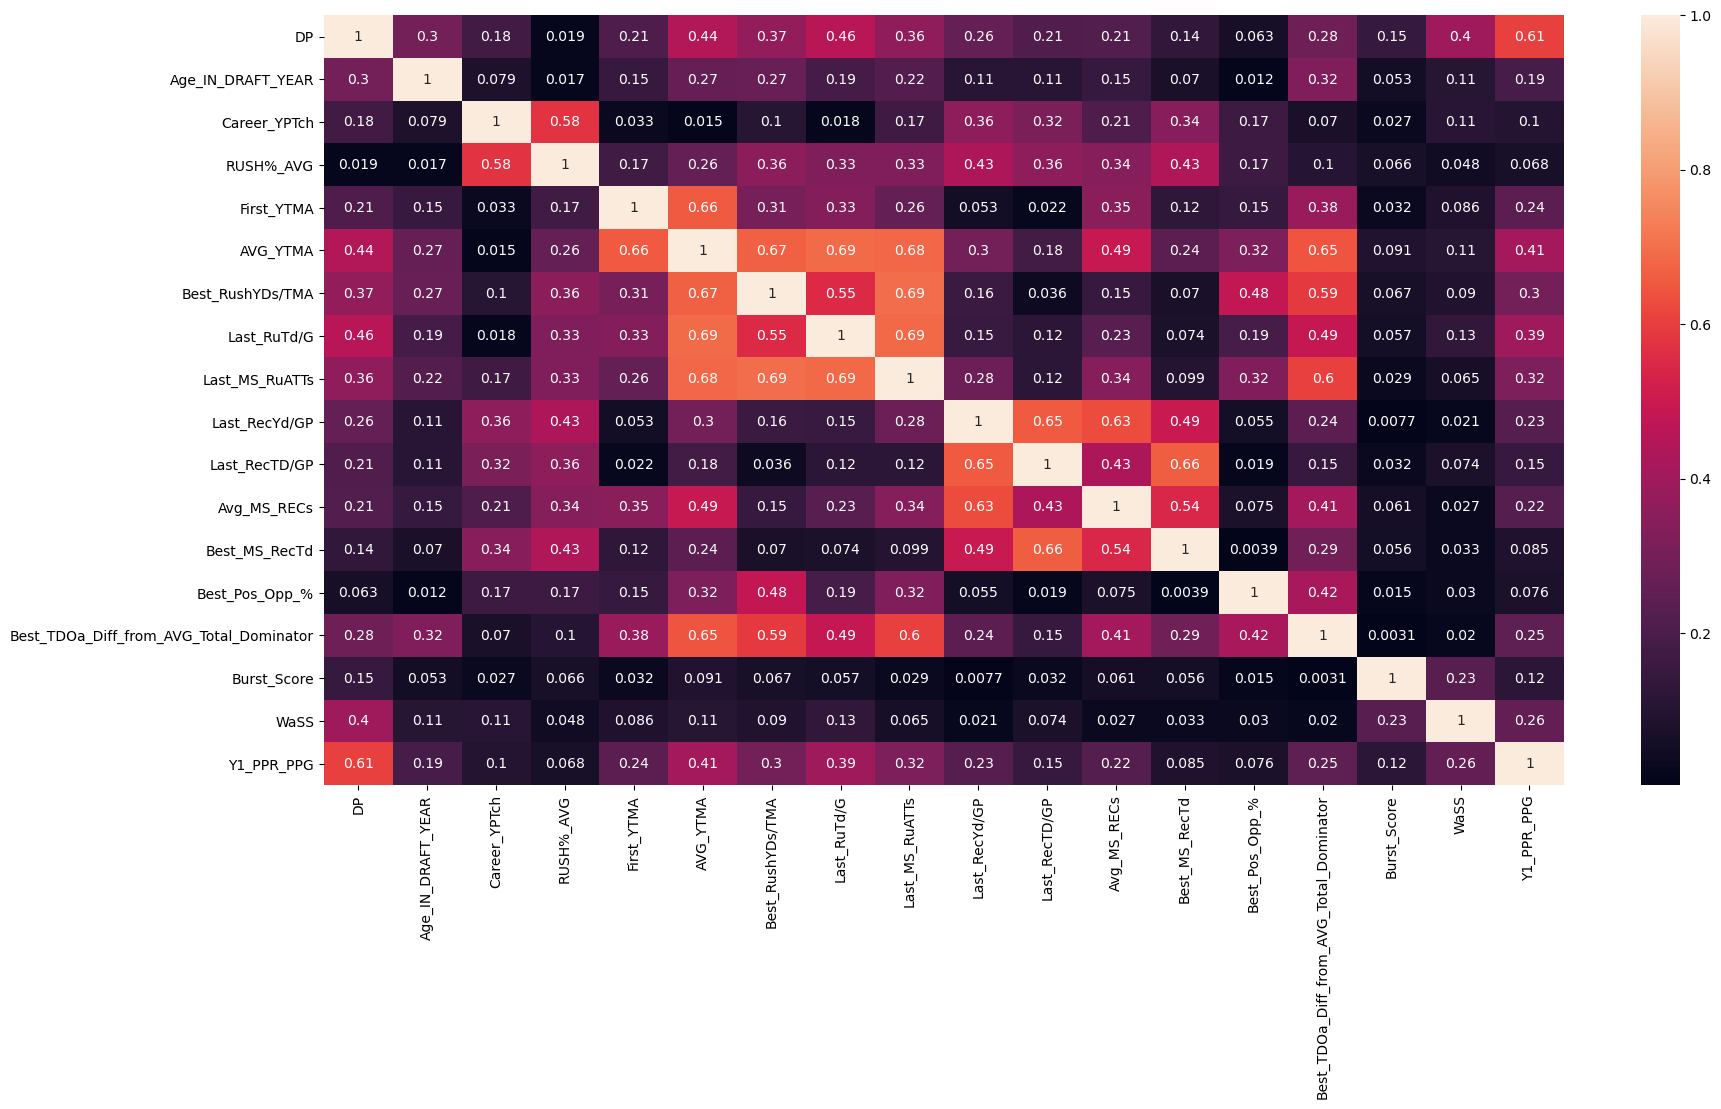

In [14]:
# Correlation Heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(abs(train_x.join(train_y).astype('float64').corr()), annot=True)

In [15]:
len(train_x.columns)

17

In [16]:
#todo:
   #set up param_grid
   #figure out best scoring function for scorers
   #note that it is fitting to train_x and train_y, maybe do it with the stratified split instead?
   #make table pretty and post
   #get scoring metrics for resume
    
param_grid = dict(
    learning_rate=[0.01,0.05],
    n_estimators=[150,200,250,300],
    subsample=[.7],
    max_features=[10,13,15,17],
    max_depth=[2],
    min_samples_leaf=[5,7,10],
    min_samples_split=[10,20,30],
)
scorer_05p = make_scorer(
    mean_pinball_loss,
    alpha=.05,
    greater_is_better=False,  # maximize the negative loss
)
scorer_95p = make_scorer(
    mean_pinball_loss,
    alpha=.95,
    greater_is_better=False,  # maximize the negative loss
)

In [17]:
# gridsearch for 0.05 quantile
gsearch_low = GridSearchCV(
    estimator=GradientBoostingRegressor(alpha=0.05,loss='quantile'),
    param_grid=param_grid,
    scoring=scorer_05p,
    n_jobs=-1,
    cv=5)
gsearch_low.fit(train_x, np.ravel(train_y))
gsearch_low.best_params_

{'learning_rate': 0.05,
 'max_depth': 2,
 'max_features': 17,
 'min_samples_leaf': 7,
 'min_samples_split': 10,
 'n_estimators': 250,
 'subsample': 0.7}

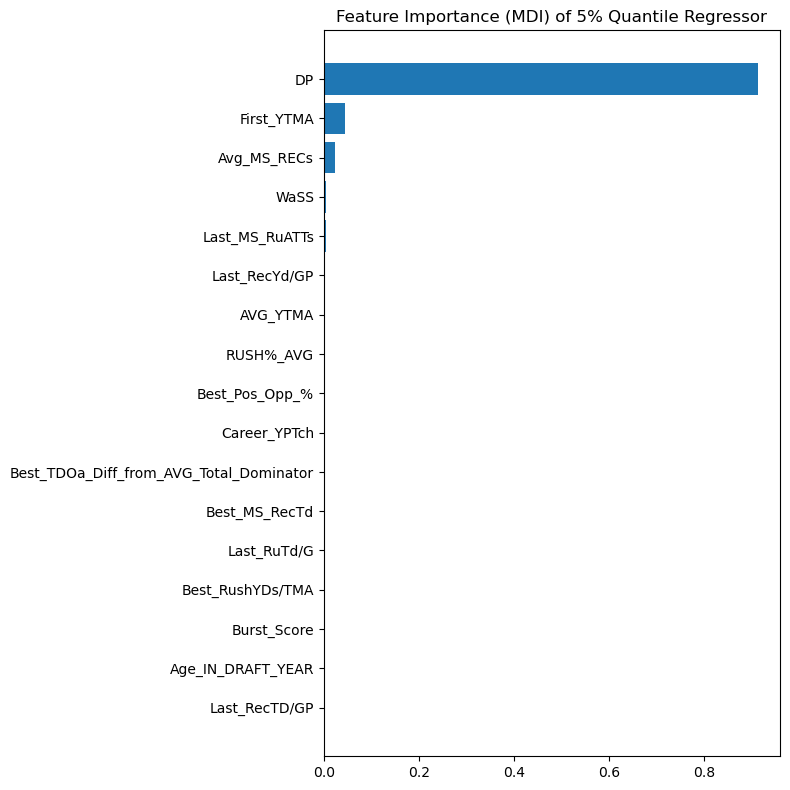

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

feature_importance = gsearch_low.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(x_all.columns)[sorted_idx])
plt.title('Feature Importance (MDI) of 5% Quantile Regressor')
fig.tight_layout()
plt.show()

In [19]:
# gridsearch for 0.50 quantile, which minimizes the mean absolute error (MAE)
# gsearch_median = GridSearchCV(
#     estimator=GradientBoostingRegressor(alpha=0.50,loss='quantile'),
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     n_jobs=-1,
#     cv=5)
# gsearch_median.fit(train_x, np.ravel(train_y))
# gsearch_median.best_params_

In [20]:
# gridsearch for 0.95 quantile
gsearch_high = GridSearchCV(
    estimator=GradientBoostingRegressor(alpha=0.95,loss='quantile'),
    param_grid=param_grid,
    scoring=scorer_95p,
    n_jobs=-1,
    cv=5)
gsearch_high.fit(train_x, np.ravel(train_y))
gsearch_high.best_params_

{'learning_rate': 0.05,
 'max_depth': 2,
 'max_features': 15,
 'min_samples_leaf': 10,
 'min_samples_split': 30,
 'n_estimators': 150,
 'subsample': 0.7}

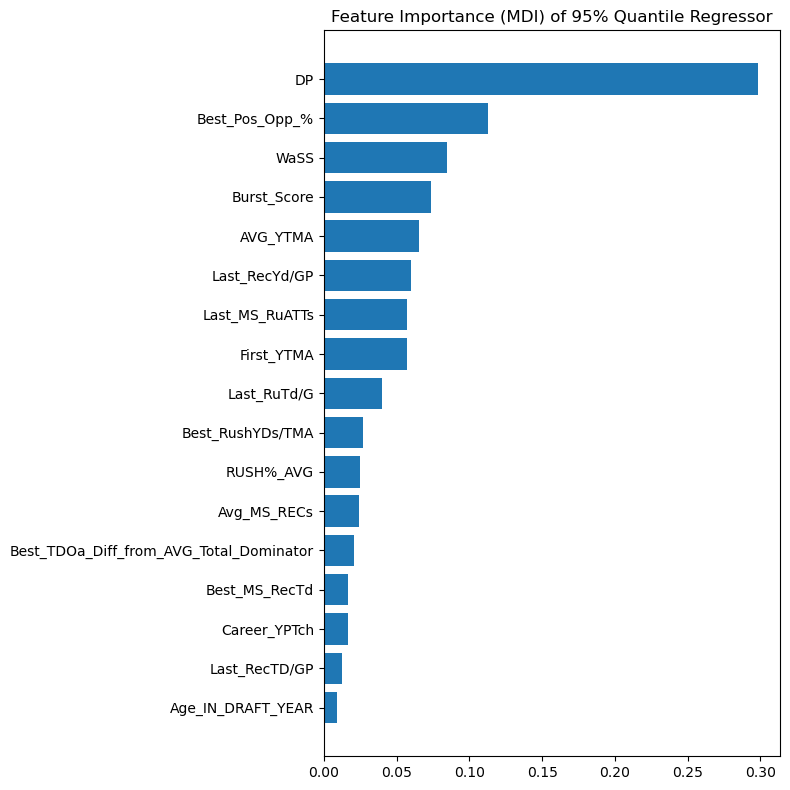

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

feature_importance = gsearch_high.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(x_all.columns)[sorted_idx])
plt.title('Feature Importance (MDI) of 95% Quantile Regressor')
fig.tight_layout()
plt.show()

In [24]:
low_preds = np.zeros(len(x_all))
#median_preds = np.zeros(len(x_all))
high_preds = np.zeros(len(x_all))
# average predictions over a range of seeds [0,99]
for x in range(100):
    low_preds = (low_preds + gsearch_low.predict(x_all))/2
#    median_preds = (median_preds + gsearch_median.predict(x_all))/2
    high_preds = (high_preds + gsearch_high.predict(x_all))/2
    
#output = pd.DataFrame({'5%':low_preds,'50%':median_preds,'95%':high_preds}).astype('float')
output = pd.DataFrame({'5%':low_preds, '95%':high_preds}).astype('float')
print("done")

done


In [25]:
pd.set_option('display.max_rows', 10000) 
pd.set_option('display.max_columns', 1000)

In [26]:
#printing results prints dataframe but takes too long to render on github
def red_background_2022(cell_value):
    highlight = 'background-color: tomato;'
    default = ''
    if cell_value == 2022:
        return highlight
    else:
        return default 
    
results = labels_all.join(y_all).join(output)
#results = labels_all.join(output)
#results = results.sort_values(by=['0.50'], ascending=False).reset_index(drop=True)
results = results.sort_values(by=['Draft_Year','95%'], ascending=False).reset_index(drop=True)
#results = results.drop('Draft Year', axis=1)
results.loc[:, "Y1_PPR_PPG"] = results["Y1_PPR_PPG"].map('{:.2f}'.format)
results["5%"] = results["5%"].map('{:.2f}'.format)
results["95%"] = results["95%"].map('{:.2f}'.format)
cm = sns.color_palette("inferno", as_cmap=True)
results1 = results.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]).background_gradient(cmap=cm, subset=['5%','95%'],vmin=-0.99, vmax=17.07)
results1.set_properties(**{'text-align': 'center'},subset=['5%','95%','Player','School'])
results.style.background_gradient(cmap=cm, subset=['5%','95%']).applymap(red_background_2022)

,Name,School,Conference,Draft_Year,Landing_Team,Y1_PPR_PPG,5%,95%
0,Bijan Robinson,Texas,Big 12,2023,nan,nan,0.03,16.76
1,Jahmyr Gibbs,Georgia Tech,ACC (Coastal),2023,nan,nan,0.02,16.45
2,Zach Charbonnet,UCLA,Pac-12 (South),2023,nan,nan,0.03,12.98
3,Tank Bigsby,Auburn,SEC (West),2023,nan,nan,0.04,10.33
4,Deuce Vaughn,Kansas State,Big 12,2023,nan,nan,0.02,10.28
5,Zach Evans,Texas Christian,Big 12,2023,nan,nan,0.02,9.49
6,Sean Tucker,Syracuse,ACC (Atlantic),2023,nan,nan,0.03,9.49
7,Devon Achane,Texas A&M,SEC (West),2023,nan,nan,0.02,9.33
8,Jo'quavious Marks,Mississippi State,SEC (West),2023,nan,nan,0.00,7.64
9,Deamonte Trayanum,Arizona State,Pac-12 (South),2023,nan,nan,0.00,6.26


In [27]:
# check the 90% interval coverage accuracy
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))


In [28]:
coverage_fraction(train_y.values.ravel(), gsearch_low.predict(train_x), gsearch_high.predict(train_x))


0.9124087591240876

In [29]:
results.to_excel("~/Desktop/rb_y1_quantiles.xlsx")